In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from shutil import copyfile
import shutil
import random
from tensorflow.keras.callbacks import ModelCheckpoint
random.seed(0)

In [2]:
shutil.rmtree('/datam')
os.makedirs('/datam/Maskdata/')
os.makedirs('/datam/Maskdata/training/')
os.makedirs('/datam/Maskdata/testing/')
os.makedirs('/datam/Maskdata/training/mask/')
os.makedirs('/datam/Maskdata/training/no_mask/')
os.makedirs('/datam/Maskdata/testing/mask/')
os.makedirs('/datam/Maskdata/testing/no_mask/')

In [3]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset=[]
    for i in os.listdir(SOURCE):
        if os.path.getsize(SOURCE+i)>0:
            dataset.append(i)
        else:
            
            print('skipped')
    train_set_size=int(len(dataset)*SPLIT_SIZE)
    test_set_size=int(len(dataset)-train_set_size)
    s=random.sample(dataset,len(dataset))
    train=s[0:train_set_size]
    test=s[:test_set_size]
    for i in train:
        y=SOURCE+i
        d=TRAINING+i
        copyfile(y,d)
    for i in test:
        y=SOURCE+i
        d=TESTING+i
        copyfile(y,d)


In [4]:
mask_source='new/mask/'
train_mask='/datam/Maskdata/training/mask/'
test_mask='/datam/Maskdata/testing/mask/'
no_mask_source='new/nomask/'
train_no_mask='/datam/Maskdata/training/no_mask/'
test_no_mask='/datam/Maskdata/testing/no_mask/'
sp=0.91
split_data(mask_source,train_mask,test_mask,sp)
split_data(no_mask_source,train_no_mask,test_no_mask,sp)

In [5]:
train_mask_dir='/datam/Maskdata/training/mask/'
train_no_mask_dir='/datam/Maskdata/training/no_mask/'
valid_mask_dir='/datam/Maskdata/testing/mask/'
valid_no_mask_dir='/datam/Maskdata/testing/no_mask/'
print(len(os.listdir(train_mask_dir)))
print(len(os.listdir(train_no_mask_dir)))
print(len(os.listdir(valid_mask_dir)))
print(len(os.listdir(valid_no_mask_dir)))

627
624
63
62


In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

model.load_weights(local_weights_file)

for layer in model.layers:
    layer.trainable = False


last_layer = model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [8]:
train_dir='/datam/Maskdata/training/'
valid_dir='/datam/Maskdata/testing/'
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
valid_datagen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_data=train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=20,
                                    class_mode='binary',
                                    target_size=(150,150))
valid_data=valid_datagen.flow_from_directory(
                    valid_dir,
                    batch_size=20,
                                    class_mode='binary',
                                    target_size=(150,150))


Found 1251 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [9]:
history = model.fit_generator(
            train_data,
            validation_data = valid_data,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 108s - loss: 0.2558 - accuracy: 0.8950 - val_loss: 0.0615 - val_accuracy: 0.9743
Epoch 2/20
100/100 - 101s - loss: 0.1305 - accuracy: 0.9521 - val_loss: 0.0297 - val_accuracy: 0.9911
Epoch 3/20
100/100 - 98s - loss: 0.1030 - accuracy: 0.9679 - val_loss: 0.0481 - val_accuracy: 0.9844
Epoch 4/20
100/100 - 97s - loss: 0.1092 - accuracy: 0.9620 - val_loss: 0.0606 - val_accuracy: 0.9855
Epoch 5/20
100/100 - 98s - loss: 0.0911 - accuracy: 0.9679 - val_loss: 0.0183 - val_accuracy: 0.9944
Epoch 6/20
100/100 - 98s - loss: 0.0772 - accuracy: 0.9744 - val_loss: 0.0374 - val_accuracy: 0.9966
Epoch 7/20
100/100 - 97s - loss: 0.0696 - accuracy: 0.9773 - val_loss: 0.0255 - val_accuracy: 0.9933
Epoch 8/20
100/100 - 98s - loss: 0.0619 - accuracy: 0.9778 - val_loss: 0.0603 - val_accuracy: 0.9888
Epoch 9/20
100/100 - 98s - loss: 0.0709 - accuracy: 0.9758 - val_loss: 0.0660 - val_accuracy: 0.9877
Epoch 10/20
100/100 - 97s - loss: 0.0983 - accuracy: 0.9663 - val_loss: 0.0382 - val_accu

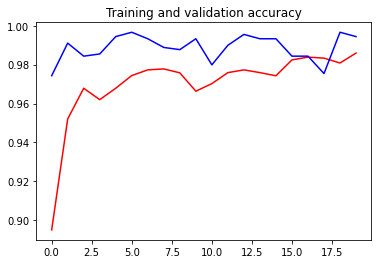

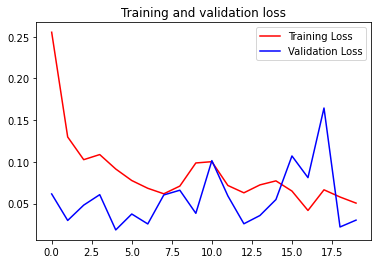

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.save('premodel.h5')